<a href="https://colab.research.google.com/github/Ali-mohammadi-design/PyTorch_for_medical_images/blob/main/Fasion__MNIST_Code_Along_with_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

Load the MNIST dataset

In [2]:
transform = transforms.ToTensor()

train_data = datasets.FashionMNIST(root='../Data', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='../Data', train=False, download=True, transform=transform)

100%|██████████| 26421880/26421880 [00:05<00:00, 4914620.17it/s]


Extracting ../Data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../Data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 204072.52it/s]


Extracting ../Data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../Data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:05<00:00, 785008.17it/s] 


Extracting ../Data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../Data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 4943286.86it/s]

Extracting ../Data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../Data/FashionMNIST/raw



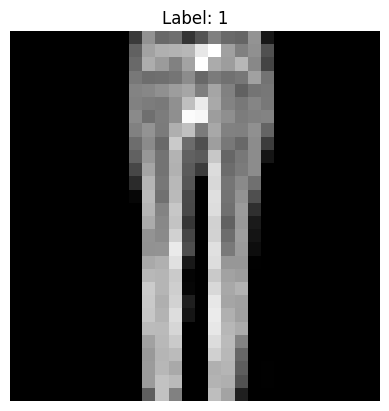

In [10]:
# Get the first image and its label
image, label = train_data[456]

# Convert the tensor back to a NumPy array for displaying
image = image.numpy()  # Shape will be (C, H, W)

# Since Matplotlib expects (H, W, C) format, we need to transpose the dimensions
image = image.transpose((1, 2, 0))

# Display the image
plt.imshow(image.squeeze(), cmap='gray')  # Use cmap='gray' for grayscale images
plt.title(f'Label: {label}')
plt.axis('off')  # Turn off axis labels
plt.show()


**Create loaders**

When working with images, we want relatively small batches; a batch size of 4 is not uncommon.

In [11]:
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [12]:
# Define layers
conv1 = nn.Conv2d(1, 6, 3, 1)
conv2 = nn.Conv2d(6, 16, 3, 1)

In [13]:
# Grab the first MNIST record
for i, (X_train, y_train) in enumerate(train_data):
    break

In [14]:
x = X_train.view(1,1,28,28)
print(x.shape)

torch.Size([1, 1, 28, 28])


In [15]:
# Perform the first convolution/activation
x = F.relu(conv1(x))
print(x.shape)

torch.Size([1, 6, 26, 26])


In [16]:
# Run the first pooling layer
x = F.max_pool2d(x, 2, 2)
print(x.shape)

torch.Size([1, 6, 13, 13])


In [17]:
# Perform the second convolution/activation
x = F.relu(conv2(x))
print(x.shape)

torch.Size([1, 16, 11, 11])


In [18]:
# Run the second pooling layer
x = F.max_pool2d(x, 2, 2)
print(x.shape)

torch.Size([1, 16, 5, 5])


In [19]:
# Flatten the data
x = x.view(-1, 5*5*16)
print(x.shape)

torch.Size([1, 400])


**This is how the convolution output is passed into the fully connected layers.**


Now let's run the code.

In [20]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 5*5*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [21]:
torch.manual_seed(42)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Define loss function & optimizer

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [29]:
import time
import torch

# Initialize variables
start_time = time.time()
epochs = 10.0  # Set epochs as a float
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# Early stopping parameters
patience = 3  # Number of epochs to wait after last improvement
best_loss = float('inf')  # Initialize the best loss
patience_counter = 0  # Counter for patience

# Main training loop
for i in range(int(epochs)):
    trn_corr = 0
    tst_corr = 0

    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        # Apply the model
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)

        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr

        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Track training loss and accuracy
    train_losses.append(loss.item())
    train_correct.append(trn_corr.item())

    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            # Apply the model
            y_val = model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()

    # Calculate validation loss
    val_loss = criterion(y_val, y_test)
    test_losses.append(val_loss.item())
    test_correct.append(tst_corr)

    # Early stopping logic
    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0  # Reset counter if we see improvement
    else:
        patience_counter += 1  # Increment counter if no improvement
        if patience_counter >= patience:
            print(f"Stopping early at epoch {i+1} due to no improvement in validation loss.")
            break  # Stop training

    # Print interim results
    if (i + 1) % 1 == 0:  # Print every epoch
        print(f'Epoch: {i+1}  Loss: {loss.item():10.8f}  \
Accuracy: {trn_corr.item()*100/len(train_loader.dataset):7.3f}%')

print(f'\nDuration: {time.time() - start_time:.0f} seconds')  # print the time elapsed


Epoch: 1  Loss: 0.07475015  Accuracy:  92.558%
Epoch: 2  Loss: 0.03728458  Accuracy:  92.705%
Epoch: 3  Loss: 0.18312040  Accuracy:  92.828%
Epoch: 4  Loss: 0.35905981  Accuracy:  93.128%
Epoch: 5  Loss: 0.00370674  Accuracy:  93.253%
Epoch: 6  Loss: 0.04391218  Accuracy:  93.533%
Epoch: 7  Loss: 0.06269125  Accuracy:  93.552%
Epoch: 8  Loss: 0.05730595  Accuracy:  93.755%
Epoch: 9  Loss: 0.16534385  Accuracy:  93.967%
Epoch: 10  Loss: 0.39764977  Accuracy:  94.037%

Duration: 593 seconds


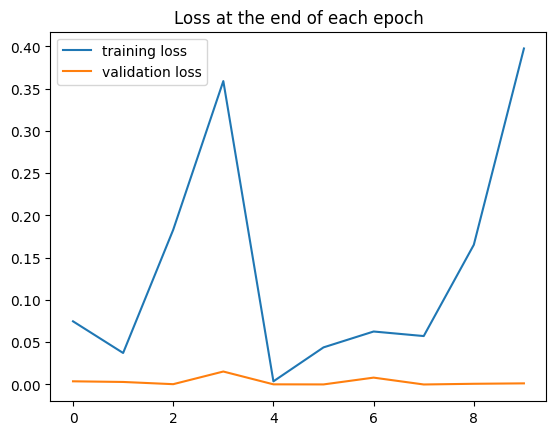

In [30]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

**Evaluate Test Data**

In [31]:
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [32]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)  # we don't flatten the data this time
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Test accuracy: 8891/10000 =  88.910%


confusion matrix

In [33]:
# print a row of values for reference
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))
print(np.arange(10).reshape(1,10))
print()

# print the confusion matrix
print(confusion_matrix(predicted.view(-1), y_test.view(-1)))

[[   0    1    2    3    4    5    6    7    8    9]]

[[ 882    6   16   16    4    1  177    0    2    0]
 [   1  964    0    2    1    0    0    0    0    0]
 [  30    1  872   15   70    0  107    0    6    0]
 [  28   22   11  897   25    0   25    0    2    0]
 [   4    3   50   50  855    0  103    0    2    0]
 [   2    0    0    0    0  974    0   30    1    4]
 [  43    2   48   17   42    0  567    0    3    1]
 [   0    0    0    0    0   13    0  952    4   45]
 [   9    2    3    3    3    0   21    1  978    0]
 [   1    0    0    0    0   12    0   17    2  950]]
